# Table of contents
*  [Introduction](#section1) 
*  [Import libraries](#section2) 
*  [EDA](#section3) 
    *  [Read the data in](#section4)
    *  [Data Exploration](#section5)
        - [Target column](#section6)
    *  [Cleaning](#section7)
        - [Irrelevant & Reduntant columns](#section8)
        - [Data leakage - Features that inject future knowledge](#section9)
        - [Columns with only one unique value](#section10)  
        - [Missing values](#section11)  
*  [Feature Engineering](#section12)
    *  [Data pre-processing: Categorical columns](#section13)
*  [Modeling and testing](#section14)
    *  [Class Imbalance](#section15)
    *  [Error Metric](#section16)
    *  [Logistic Regression Model - Cross Validation](#section17)  
    *  [Random Forests](#section18)  
    *  [Ensembled model: LightGBM + XGBoost](#section19)
        - [LightGBM](#section20)
        - [XGBoost](#section21)
        - [Ensemble](#section30)
*  [Feature Importance](#section22)
*  [Conclusions](#section23)
    
by @samaxtech

---
<a id='section1'></a>
# Introduction
This project aims to build different machine learning models to model credit risk, by classifing borrowers and predict whether they will pay off their loan on time or not, as a binary classification problem. The data consists on approved loans data from 2007 to 2011 from Lending Club (https://www.lendingclub.com/), a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. 

---
<a id='section2'></a>
# Import libraries

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

/Users/sama/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


---
<a id='section3'></a>
# EDA
<a id='section4'></a>
## Read the data in

In [2]:
loans_2007 = pd.read_csv('loans_2007.csv', low_memory=False)

print(loans_2007.shape)
loans_2007.head()

(42538, 52)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


---
<a id='section5'></a>
## Data Exploration
<a id='section6'></a>
### Target column
Firstly, let's study the **'loan_status'** column. This will be, after some processing, the target column since it's the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower.

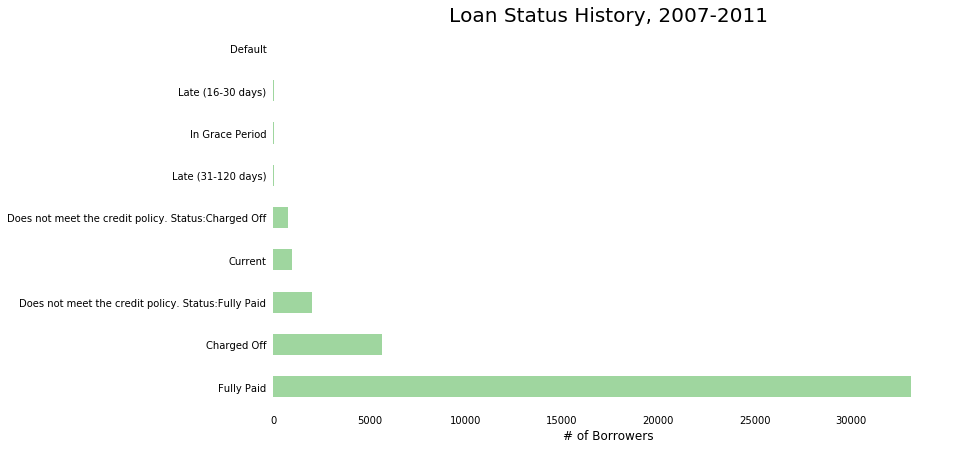

In [3]:
freq_loan_status = loans_2007['loan_status'].value_counts() 

fig, ax = plt.subplots(figsize=(12,7))
freq_loan_status.plot(kind='barh',alpha=0.75, rot=0, colormap=plt.cm.Accent)

plt.title('Loan Status History, 2007-2011', size=20)
plt.xlabel('# of Borrowers', size=12)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(top="off", left="off", right="off", bottom='off')

The explanation for each status as well as the counts in the loans_2007 Dataframe is:

- **Fully Paid (33136):** Loan has been fully paid off.
- **Charged Off (5634):** Loan for which there is no longer a reasonable expectation of further payments.
- **Does not meet the credit policy. Status - Fully Paid (1988):** While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.
- **Does not meet the credit policy. Status - Charged Off (761):** While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.
- **In Grace Period	(20):** The loan is past due but still in the grace period of 15 days.
- **Late (16-30 days) (8):** Loan hasn't been paid in 16 to 30 days (late on the current payment).
- **Late (31-120 days) (24):** Loan hasn't been paid in 31 to 120 days (late on the current payment).
- **Current	(961):** Loan is up to date on current payments.
- **Default	(3):** Loan is defaulted on and no payment has been made for more than 121 days.

---
Since we're interested in being able to predict which of these 2 values a loan will fall under:
- Fully Paid **(1)**
- Charged Off **(0)**

We can treat the problem as a **binary classification** one. Let's remove all the loans that don't contain either Fully Paid or Charged Off as the loan's status and then transform the Fully Paid values to 1 for the positive case and the Charged Off values to 0 for the negative case. 

In [4]:
# Remove loans that don't contain either Fully Paid or Charged Off
loans_2007 = loans_2007[(loans_2007['loan_status'] == 'Fully Paid') | (loans_2007['loan_status'] == 'Charged Off')]


# Map Fully Paid/Charged Off to 0/1
mapping_dict = {
    'loan_status':{
        'Fully Paid':1,
        'Charged Off':0
    }
}

loans_2007.replace(mapping_dict, inplace=True)

print("\n----------------------------------\nShape after target col processing\n----------------------------------\n", loans_2007.shape)


----------------------------------
Shape after target col processing
----------------------------------
 (38770, 52)


It should also be pointed out that there is a class imbalance between Fully Paid and Charged Off, given the difference in the amount of values between both. That will be tackled later on.

---
<a id='section7'></a>
## Cleaning
Let's focus on columns that:

1. Leak information from the future (after the loan has already been funded).
2. Don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club).
3. Formatted poorly and need to be cleaned up.
4. Require more data or a lot of processing to turn into a useful feature.
5. Contain redundant information.
6. Only contain one value, since they don't add any information to each loan application and won't be useful for the model.

---
<a id='section8'></a>
### Irrelevant & Reduntant columns
In order not to take into account columns that don't affect a borrower's ability to pay back a loan and contain redundant information, the following features need to be removed:

- **id:** randomly generated field by Lending Club for unique identification purposes only
- **member_id:** also a randomly generated field by Lending Club for unique identification purposes only
- **funded_amnt:** leaks data from the future (after the loan has already started to be funded)
- **funded_amnt_inv:** also leaks data from the future (after the loan has already started to be funded)
- **grade:** contains redundant information as the interest rate column ('int_rate', which contains continuous values, which are better suited for machine learning). 
- **sub_grade:** also contains redundant information as the interest rate column.
- **emp_title:** requires other data and a lot of processing to potentially be useful
- **issue_d:** leaks data from the future (after the loan is already completed funded)
- **zip_code:** redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)

In [5]:
cols_drop_1 = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv', 'grade', 
               'sub_grade', 'emp_title', 'issue_d', 'zip_code']

loans_2007.drop(cols_drop_1, axis=1, inplace=True)

<a id='section9'></a>
### Data leakage - Features that inject future knowledge
To prevent our model from overfitting and using data about the target column that wouldn't be available when we're using the model on future loans, the following features need to be removed:

- **out_prncp:** leaks data from the future, (after the loan already started to be paid off)
- **out_prncp_inv:** also leaks data from the future.
- **total_pymnt:** also leaks data from the future.
- **total_pymnt_inv:** also leaks data from the future.
- **total_rec_prncp:** also leaks data from the future.
- **total_rec_int:** leaks data from the future.
- **total_rec_late_fee:** also leaks data from the future.
- **recoveries:** also leaks data from the future.
- **collection_recovery_fee:** also leaks data from the future.
- **last_pymnt_d:** also leaks data from the future.
- **last_pymnt_amnt:** also leaks data from the future.

In [6]:
cols_drop_2 = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
              'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
              'last_pymnt_d', 'last_pymnt_amnt']

loans_2007.drop(cols_drop_2, axis=1, inplace=True)
print("\n--------------------------\nShape after dropping cols\n--------------------------\n", loans_2007.shape)


--------------------------
Shape after dropping cols
--------------------------
 (38770, 32)


<a id='section10'></a>
### Columns with only one unique value
To check the number of unique values on each column and drop those with only one, let's use the following approach:

For each column:
- Drop any null values.
- Check the number of unique values.
- Remove the col if the previous number is equal to 1.

In [7]:
print("\n-----------------------------------\nColumns with only one unique value\n-----------------------------------")
      
for col in loans_2007.columns:
    # Drop any null values
    non_null = loans_2007[col].dropna()
    
    # Check the number of unique values
    unique_non_null = non_null.unique()
    num_true_unique = len(unique_non_null)
    
    # Remove the col if there is only 1 unique value
    if num_true_unique == 1:
        loans_2007.drop(col, axis=1, inplace=True)
        print(col)


-----------------------------------
Columns with only one unique value
-----------------------------------
pymnt_plan
initial_list_status
collections_12_mths_ex_med
policy_code
application_type
acc_now_delinq
chargeoff_within_12_mths
delinq_amnt
tax_liens


<a id='section11'></a>
### Missing values
Let's remove any columns with more than 1% of missing values, keeping 'emp_length', since it contains the number of years the borrower was employed upon time of application, which is likely to be useful for the model given what we want to predict.

In [8]:
null_values = loans_2007.isnull().sum()
print("\n-----------------------------------\nPercentage of missing values (%):\n-----------------------------------\n", null_values*100 / len(loans_2007))


-----------------------------------
Percentage of missing values (%):
-----------------------------------
 loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
emp_length              2.672169
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.028372
addr_state              0.000000
dti                     0.000000
delinq_2yrs             0.000000
earliest_cr_line        0.000000
inq_last_6mths          0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.128966
total_acc               0.000000
last_credit_pull_d      0.005159
pub_rec_bankruptcies    1.797782
dtype: float64


In [9]:
more_than_1pct = ['pub_rec_bankruptcies']
loans_2007.drop(more_than_1pct, axis=1, inplace=True)

Next, after dropping those columns let's remove any remaining rows that contain null values.

In [10]:
loans_2007.dropna(inplace=True)
print("\n----------------------\nShape after cleaning\n----------------------\n", loans_2007.shape)


----------------------
Shape after cleaning
----------------------
 (37675, 22)


---
<a id='section12'></a>
# Feature Engineering
<a id='section13'></a>
## Data pre-processing: Categorical columns
Let's see how many columns have object type, and check the number of unique values for those.

In [11]:
object_cols = list(loans_2007.select_dtypes(include=['object']).columns)
print("\n----------------------\nObject columns\n----------------------")
print(object_cols)


----------------------
Object columns
----------------------
['term', 'int_rate', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'addr_state', 'earliest_cr_line', 'revol_util', 'last_credit_pull_d']


In [12]:
print("\n-----------------------------\nUnique values in object cols\n-----------------------------")
for col in object_cols:
    print(col, ":", len(loans_2007[col].unique()))


-----------------------------
Unique values in object cols
-----------------------------
term : 2
int_rate : 371
emp_length : 11
home_ownership : 5
verification_status : 3
purpose : 14
title : 18881
addr_state : 50
earliest_cr_line : 514
revol_util : 1086
last_credit_pull_d : 107


---
The resulting columns include:

- **home_ownership:** home ownership status, can only be 1 of 4 categorical values according to the data dictionary.
- **verification_status:** indicates if income was verified by Lending Club.
- **emp_length:** number of years the borrower was employed upon time of application.
- **term:** number of payments on the loan, either 36 or 60.
- **addr_state:** borrower's state of residence.
- **purpose:** a category provided by the borrower for the loan request.
- **title:** loan title provided the borrower.

In addition, there are two columns that represent numeric values, that need to be converted:

- **int_rate:** interest rate of the loan in %,
- **revol_util:** revolving line utilization rate or the amount of credit the borrower is using relative to all available credit, read more here.

Lastly, the following columns would need a solid feature engineering to be useful for the model. 

- **earliest_cr_line:** The month the borrower's earliest reported credit line was opened,
- **last_credit_pull_d:** The most recent month Lending Club pulled credit for this loan.

---
For performance purposes, let's start by removing 'addr_state', and 'title', since they contain too many discrete values and we'd need to add too many dummy variable columns to use them for classification. Also, let's convert 'earliest_cr_line' and 'last_credit_pull_d' to numerical.

In [13]:
cols_drop = ['addr_state', 'title']
loans_2007.drop(cols_drop, axis=1, inplace=True)

for col in ['last_credit_pull_d', 'earliest_cr_line']:
    loans_2007.loc[:, col] = pd.DatetimeIndex(loans_2007[col]).astype(np.int64)*1e-9

Next, let's convert 'int_rate' and 'revol_util' to float columns.

In [14]:
float_cols = ['int_rate', 'revol_util']
for col in float_cols:
    loans_2007[col] = loans_2007[col].str.rstrip('%').astype(float)
    
loans_2007[float_cols].head()

,int_rate,revol_util
0,10.65,83.7
1,15.27,9.4
2,15.96,98.5
3,13.49,21.0
5,7.90,28.3


To clean the 'emp_length' column, we can use the following mapping:

- "10+ years": 10
- "9 years": 9
- "8 years": 8
- "7 years": 7
- "6 years": 6
- "5 years": 5
- "4 years": 4
- "3 years": 3
- "2 years": 2
- "1 year": 1
- "< 1 year": 0
- "n/a": 0

In [15]:
mapping_dict = {
    'emp_length': {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0,
        'n/a': 0
    }
}

loans_2007.replace(mapping_dict, inplace=True)

Now, let's encode 'home_ownership', 'verification_status', 'term', and 'purpose' as dummy variables.

In [16]:
dummy_cols = ['home_ownership', 'verification_status', 'term', 'purpose']

for col in dummy_cols:
    dummy_df = pd.get_dummies(loans_2007[col])
    loans_2007 = pd.concat([loans_2007, dummy_df], axis=1)
    loans_2007.drop(col, axis=1, inplace=True)    

Lastly, let's take a look at how the 'loans_2007' Dataframe looks like after preprocessing.

In [17]:
print("\n----------------------------------\nShape after pre-processing\n----------------------------------\n", loans_2007.shape)
loans_2007.head()


----------------------------------
Shape after pre-processing
----------------------------------
 (37675, 40)


,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,...,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,5000.0,10.65,162.87,10,24000.0,1,27.65,0.0,4.733856e+08,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,15.27,59.83,0,30000.0,0,1.00,0.0,9.229248e+08,5.0,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,15.96,84.33,10,12252.0,1,8.72,0.0,1.004573e+09,2.0,...,0,0,0,0,0,0,0,1,0,0
3,10000.0,13.49,339.31,10,49200.0,1,20.00,0.0,8.231328e+08,1.0,...,0,0,0,0,0,1,0,0,0,0
5,5000.0,7.90,156.46,3,36000.0,1,11.20,0.0,1.099267e+09,3.0,...,0,0,0,0,0,0,0,0,0,1


---
<a id='section14'></a>
# Modeling and Testing
<a id='section15'></a>
## Class Imbalance
As I mentioned earlier, there are 6 times as many loans that were paid off on time (1), than loans that weren't paid off on time (0) in the dataset. This means even if the classifier predicted all ones (all loans will be paid off on time, which would make us lose money for a decent amount of cases, the model would still have a high accuracy).

As an example, if there were 6 loans that were paid off on time and 1 that wasn't, if our model predicted all ones that'd mean that investing 1000 dollars with a 10 percent interest on each one would lose us $400 overall.

- **(<font color='green'>100</font>x6) - (<font color='red'>1000</font>x1) = <font color='red'>-400</font> dollars**

That's why using accuracy for this particular dataset is not a good idea. Instead, we can compute the True Positive Rate (TPR) (high recall) and False Positive Rate (FPR) (low fall-out).


<a id='section16'></a>
## Error Metric
Following what I mentioned in the 'Class Imbalance' section, our objective is to predict whether or not we should fund a loan based on whether a borrower will pay off their loan on time or not. Since the ultimate objective is to make money, ideally we want to fund enough loans that are paid off on time to offset our losses from loans that aren't paid off. 

From an investor perspective, we want to pay attention to:

- **False Positives (FP):** the model predicts a loan will be paid off on time, but it actually isn't.
- **False Negatives (FN):** the model predicts a loan will not be paid off on time, but it actually is.

False Positives (FP) will cost us money, and False Negatives (FN) will lose us potential money. From the perspective of a conservative investor and to minimize risk, we need to avoid false positives as much as possible, since losing actual money by funding a risky loan (false positives) would be worse than losing potential money by missing out on opportunities (false negatives).

To sum it up, the error metric will be based on:

| loan_status (Actual) | Prediction   |     Error Type     |
|----------------------|--------------|--------------------|
|          0           |       1      | False Positive (FP)
|          1           |       1      | True Positive (TP)
|          0           |       0      | True Negative (TN)
|          1           |       0      | False Negative (FN)

So that we can compute the True Positive Rate (TPR) and False Positive Rate (FPR), as follows:

- **FPR = FP / (FP + TN)**, which divides all the cases where we thought a loan would be paid off but it wasn't by all the loans that weren't paid off (what percentage of the loans that I fund would not be repaid).
- **TPR = TP / (TP + FN)**, which divides all the cases where we thought a loan would be paid off and it was by all the loans that were paid off (what percentage of loans that could be funded would I fund).

Let's create a function to calculate FPR and TPR from the actual and predicted values of a model.

In [18]:
def tpr_fpr(actual, predicted):
    # FP
    fp_filter = (actual == 0) & (predicted == 1)
    fp = len(predicted[fp_filter])
    
    # TP
    tp_filter = (actual == 1) & (predicted == 1) 
    tp = len(predicted[tp_filter])

    # TN
    tn_filter = (actual == 0) & (predicted == 0)
    tn = len(predicted[tn_filter])
    
    # FN
    fn_filter = (actual == 1) &(predicted == 0)
    fn = len(predicted[fn_filter])

    tpr = tp  / (tp + fn)
    fpr = fp  / (fp + tn)
    
    return(fpr, tpr)

---
<a id='section17'></a>
## Logistic Regression Model - Cross Validation
Let's start out by testing a logistic regression model performance by using a 3-fold cross validation.

In [19]:
# Data preparation
target = 'loan_status'
X_train = loans_2007.loc[:, loans_2007.columns != target]
y_train = loans_2007[target]

# LR Model
lr = LogisticRegression()

# Train
predictions_lr = cross_val_predict(lr, X_train, y_train, cv=3)
predictions_lr = pd.Series(predictions_lr)

# Test performance - FPR and TPR
fpr_lr, tpr_lr = tpr_fpr(y_train, predictions_lr)

print("\n----------------------------------\nLogistic Regression\n----------------------------------")
print("FPR:", fpr_lr)
print("TPR:", tpr_lr)


----------------------------------
Logistic Regression
----------------------------------
FPR: 1.0
TPR: 1.0


We can see that the FPR and TPR are around what we'd expect if the model was predicting all ones. This is because even though we're not using accuracy as an error metric, the classifier is, and it isn't accounting for the imbalance in the classes.

In order to solve that, we can either:

1. Use oversampling and undersampling to ensure that the classifier gets input that has a balanced number of each class.
2. Tell the classifier to penalize misclassifications of the less prevalent class more than the other class.

For the purpose of this project and because of the ease of implementation in scikit-learn, I will use the second method. To do so, let's change the 'class_weight' parameter in the LogisticRegression instance, which will penalize the misclassification of the minority class (0) during the training process.

In [20]:
penalty = {
    0: 7,
    1: 1
}

# LR Model
lr = LogisticRegression(class_weight=penalty)

# Train
predictions_lr = cross_val_predict(lr, X_train, y_train, cv=3)
predictions_lr = pd.Series(predictions_lr)

# Test performance - FPR and TPR
fpr_lr, tpr_lr = tpr_fpr(y_train, predictions_lr)

print("\n----------------------------------\nLogistic Regression\n----------------------------------")
print("FPR:", fpr_lr)
print("TPR:", tpr_lr)


----------------------------------
Logistic Regression
----------------------------------
FPR: 0.09753208292201382
TPR: 0.1013371788148925


We can see how the FPR fell to around 9%. While this means that an investor will be able to do a better job at avoiding bad loans than if he/she funded everything, the TPR also fell to around 10%, which means that same investor will decide to fund only 10% of the total loans that are going to be paid off.

---
<a id='section18'></a>
## Random Forests
Let's test a random forest model with a higher class weight penalty.

In [21]:
penalty = {
    0: 10,
    1: 1
}

# RF Model
rf = RandomForestClassifier(class_weight=penalty, random_state=1)

# Train
predictions_rf = cross_val_predict(rf, X_train, y_train, cv=3)
predictions_rf = pd.Series(predictions_rf)

# Test performance - FPR and TPR
fpr_rf, tpr_rf = tpr_fpr(y_train, predictions_rf)

print("\n----------------------------------\nRandom Forests\n----------------------------------")
print("FPR:", fpr_rf)
print("TPR:", tpr_rf)


----------------------------------
Random Forests
----------------------------------
FPR: 0.9569595261599211
TPR: 0.9542475091767174


While the TPR went up again, it looks like the model is likely weighting too heavily on the 1 class, and still mostly predicting ones.

<a id='section19'></a>
## Ensembled model: LightGBM + XGBoost
Lastly, let's test LightGBM and XGBoost on an ensemble model.

In [22]:
# Data Preparation
X = loans_2007.loc[:, loans_2007.columns != target]
y = loans_2007[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("------------------------------------------------\nShapes:\n------------------------------------------------")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

------------------------------------------------
Shapes:
------------------------------------------------
(25242, 39) (12433, 39) (25242,) (12433,)


<a id='section20'></a>
### LightGBM

In [23]:
# Model
lgb_params = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_lgb = np.zeros(len(X_train))
predictions_lgb = np.zeros(len(X_test))

features_lgb = list(X_train.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(X_train)):
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    
# Test performance - FPR and TPR
fpr_lgb, tpr_lgb = tpr_fpr(y_test, np.round(predictions_lgb))

print("\n----------------------------------\nLightGBM\n----------------------------------")
print("FPR:", fpr_lgb)
print("TPR:", tpr_lgb)

LGB 0--------------------------------------------------
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 0.319349	valid_1's rmse: 0.324839
[400]	training's rmse: 0.307207	valid_1's rmse: 0.32128
[600]	training's rmse: 0.298754	valid_1's rmse: 0.320245
[800]	training's rmse: 0.29188	valid_1's rmse: 0.319989
[1000]	training's rmse: 0.286081	valid_1's rmse: 0.319882
[1200]	training's rmse: 0.280975	valid_1's rmse: 0.319889
[1400]	training's rmse: 0.27628	valid_1's rmse: 0.32009
Early stopping, best iteration is:
[1026]	training's rmse: 0.285382	valid_1's rmse: 0.319839
LGB 1--------------------------------------------------
Training until validation scores don't improve for 500 rounds.
[200]	training's rmse: 0.31945	valid_1's rmse: 0.326898
[400]	training's rmse: 0.307656	valid_1's rmse: 0.321935
[600]	training's rmse: 0.29944	valid_1's rmse: 0.320243
[800]	training's rmse: 0.292708	valid_1's rmse: 0.31958
[1000]	training's rmse: 0.28705	valid_1's rmse

<a id='section21'></a>
### XGBoost

In [25]:
xgb_params = {'eta': 0.001, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_xgb = np.zeros(len(X_train))
predictions_xgb = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(X_train)):
    trn_data = xgb.DMatrix(data=X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = xgb.DMatrix(data=X_train.iloc[val_idx], label=y_train.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 2000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=10, verbose_eval=200)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(X_train.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits
    
    
# Test performance - FPR and TPR
fpr_xgb, tpr_xgb = tpr_fpr(y_test, np.round(predictions_xgb))

print("\n----------------------------------\nXGBoost\n----------------------------------")
print("FPR:", fpr_xgb)
print("TPR:", tpr_xgb)

xgb 0--------------------------------------------------
[0]	train-rmse:0.499704	valid-rmse:0.499717
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[200]	train-rmse:0.447687	valid-rmse:0.450048
[400]	train-rmse:0.408104	valid-rmse:0.413104
[600]	train-rmse:0.378232	valid-rmse:0.386069
[800]	train-rmse:0.355913	valid-rmse:0.366592
[1000]	train-rmse:0.339218	valid-rmse:0.35274
[1200]	train-rmse:0.326684	valid-rmse:0.342958
[1400]	train-rmse:0.317196	valid-rmse:0.33613
[1600]	train-rmse:0.309907	valid-rmse:0.331359
[1800]	train-rmse:0.304199	valid-rmse:0.328022
[1999]	train-rmse:0.299649	valid-rmse:0.325667
xgb 1--------------------------------------------------
[0]	train-rmse:0.499703	valid-rmse:0.499713
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[200]	train-rmse:0.447637	valid-rmse:0.450212


<a id='section30'></a>
### Ensemble

In [26]:
# Test performance - FPR and TPR (Ensemble)
fpr_ens, tpr_ens = tpr_fpr(y_test, np.round(0.5*predictions_lgb + 0.5*predictions_xgb))

print("\n----------------------------------\nEnsemble\n----------------------------------")
print("FPR:", fpr_ens)
print("TPR:", tpr_ens)


----------------------------------
Ensemble
----------------------------------
FPR: 0.928686327077748
TPR: 0.9941332323996972


---
<a id='section22'></a>
# Feature Importance

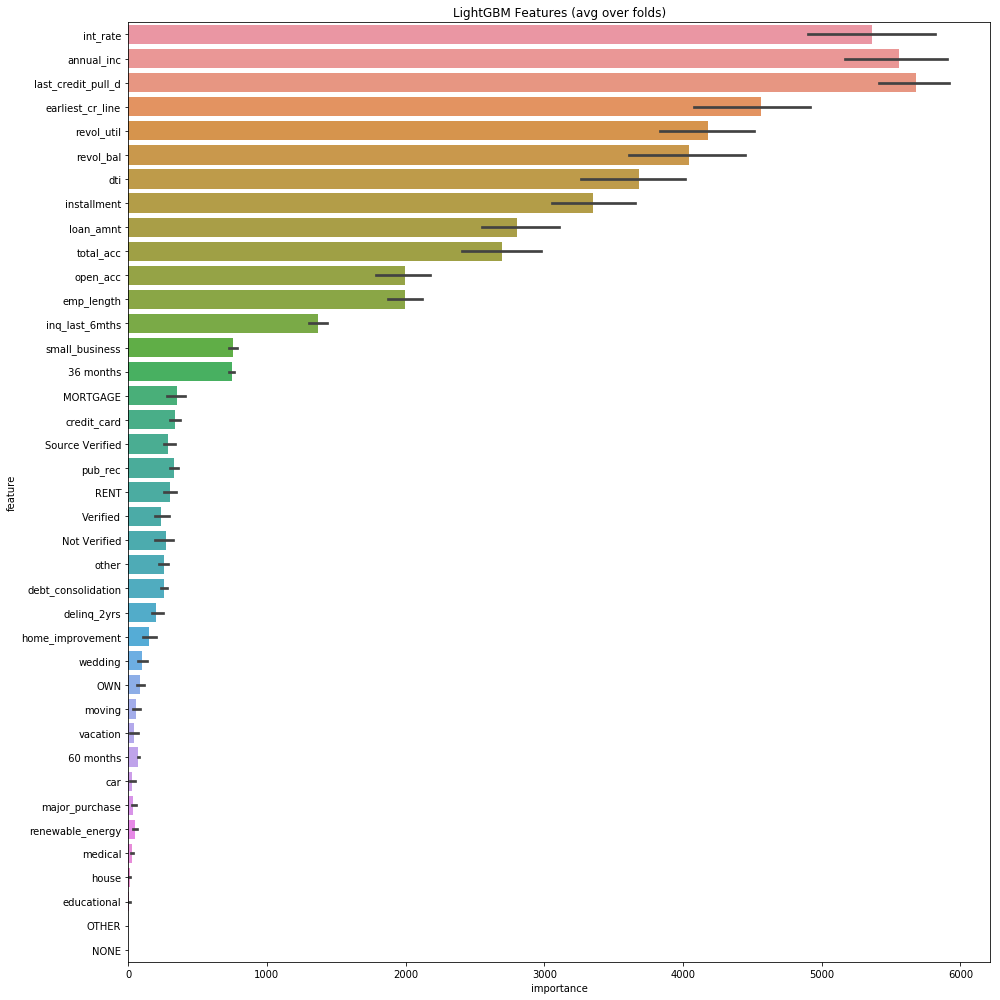

In [27]:
import seaborn as sns

cols = (feature_importance_df_lgb[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

---
<a id='section23'></a>
# Conclusions
It looks like the last model is still weighting too heavily on the 1 class, and mostly predicting ones. However, we've tested the performance of difference models and seen the effect of tweaking the penalties for LR and RF.

If we take other approaches to handle the class imbalance and achieve a more balanced dataset to test the models, the quality of the observations will improve and we could get a more accurate value of TPR and FPR.

As a conclusion, for a conservative investor, given that the model returned a certain TPR and FPR (say 9% FPR and 10% TPR, like the Logistic Regression model previously tested), it means that he/she will make money as long as the interest rate is high enough to offset the losses from 9% of borrowers defaulting, and that the pool of 10% of borrowers is large enough to make enough interest money to offset the losses.